In [1]:
import numpy as np
import torch
import random

In [2]:
#====================Random seed====================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 100% deterministic but slower training
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [3]:
#====================Dataset====================
import cv2
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

batch_size = 256

class dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data=data
        self.transform=transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, _ = self.data[idx]
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        if self.transform:
            img = self.transform(img)
            L = img[0:1, :, :]
            ab = (img[1:3, :, :]*255 - 128) / 128
        else:
            img = torch.from_numpy(img.transpose(2,0,1)).float()
            L = img[0:1, :, :] / 255
            ab = (img[1:3, :, :]- 128) / 128
        return L, ab
train_dataset = dataset(datasets.CIFAR10(root="./data", train=True, download=True), transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_dataset = dataset(datasets.CIFAR10(root="./data", train=False, download=True), transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

100%|██████████| 170M/170M [00:08<00:00, 20.5MB/s]


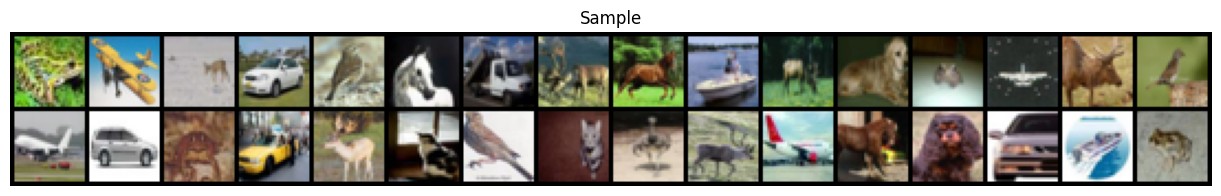

In [4]:
#====================Show data====================
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def imshow(L, ab, title):
    L = L * 255
    ab = ab * 128 + 128
    img = np.concatenate([L.numpy(), ab.numpy()], axis=1)
    img = img[:32, :, :, :]
    img = np.transpose(img, (0, 2, 3, 1))
    img = np.clip(np.rint(img), 0, 255).astype(np.uint8)
    img = [torch.from_numpy(cv2.cvtColor(img[i], cv2.COLOR_LAB2RGB)).permute(2, 0, 1) for i in range(len(img))] # conver lab to rgb
    img = torch.stack(img, dim=0)
    grid = make_grid(img, nrow=16, padding=2)
    
    plt.figure(figsize=(16,2))
    plt.imshow(grid.permute(1,2,0).numpy()) 
    plt.title(title)
    plt.axis('off')
    plt.show()

L, ab = next(iter(train_dataloader))
imshow(L, ab, "Sample")

In [5]:
#====================Generator====================
import torch
import torch.nn as nn

def conv_block(in_c, out_c, norm=True):
    layers = [nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1, bias=not norm)]
    if norm: layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.LeakyReLU(0.2, inplace=True))  # encoder use LeakyReLU
    return nn.Sequential(*layers)

def deconv_block(in_c, out_c, norm=True, dropout=False):
    layers = [nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1, bias=not norm)]
    if norm: layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.ReLU(inplace=True))            # decoder use ReLU
    if dropout: layers.append(nn.Dropout(0.5))
    return nn.Sequential(*layers)

def conv3x3_halve(in_c, out_c):
    # 3x3 stride=1 + BN + ReLU (paper: "3×3 conv, stride 1, halving channels, BN+ReLU")
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

class UNetGenerator(nn.Module):
    def __init__(self, in_ch=1, out_ch=2):
        super().__init__()
        # Encoder (green, 4x4 s2; first has no BN)
        self.e1 = nn.Conv2d(in_ch, 64, kernel_size=4, stride=2, padding=1)   # 32->16
        self.e2 = conv_block(64, 128)                                        # 16->8
        self.e3 = conv_block(128, 256)                                       # 8->4
        self.e4 = conv_block(256, 512)                                       # 4->2
        self.e5 = conv_block(512, 512)                                       # 2->1 (bottleneck 1x1)

        # Decoder (orange, 4x4 deconv s2) + concat + 3x3 conv (BN+ReLU)
        self.d1 = deconv_block(512, 512, dropout=True)                       # 1->2
        self.cat1 = conv3x3_halve(512 + 512, 512)                            # [d1||e4] -> 512

        self.d2 = deconv_block(512, 256, dropout=True)                       # 2->4
        self.cat2 = conv3x3_halve(256 + 256, 256)                            # [d2||e3] -> 256

        self.d3 = deconv_block(256, 128, dropout=True)                       # 4->8
        self.cat3 = conv3x3_halve(128 + 128, 128)                            # [d3||e2] -> 128

        self.d4 = deconv_block(128, 64, dropout=False)                       # 8->16
        self.cat4 = conv3x3_halve(64 + 64, 64)                               # [d4||e1] -> 64  (16x16)

        self.up_final = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 16->32
        self.final    = nn.Conv2d(64, out_ch, kernel_size=1, stride=1)       # 1x1 conv
        self.tanh     = nn.Tanh()

    def forward(self, x):
        # Encoder
        e1 = self.e1(x)          # [B, 64, 16, 16]
        e2 = self.e2(e1)         # [B,128,  8,  8]
        e3 = self.e3(e2)         # [B,256,  4,  4]
        e4 = self.e4(e3)         # [B,512,  2,  2]
        b  = self.e5(e4)         # [B,512,  1,  1]

        # Decoder + skips
        d1 = self.d1(b)                          # -> [B,512, 2, 2]
        c1 = self.cat1(torch.cat([d1, e4], 1))   # -> [B,512, 2, 2]

        d2 = self.d2(c1)                         # -> [B,256, 4, 4]
        c2 = self.cat2(torch.cat([d2, e3], 1))   # -> [B,256, 4, 4]

        d3 = self.d3(c2)                         # -> [B,128, 8, 8]
        c3 = self.cat3(torch.cat([d3, e2], 1))   # -> [B,128, 8, 8]

        d4 = self.d4(c3)                         # -> [B, 64,16,16]
        c4 = self.cat4(torch.cat([d4, e1], 1))   # -> [B, 64,16,16]

        u  = self.up_final(c4)                   # -> [B, 64,32,32]
        out = self.final(u)                      # -> [B,  2,32,32]
        return self.tanh(out)


In [6]:
#====================Dicriminator====================
def d_block(in_c, out_c, k=4, s=2, p=1, use_bn=True):
    layers = [nn.Conv2d(in_c, out_c, k, s, p, bias=not use_bn)]
    if use_bn:
        layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

class PatchDiscriminator(nn.Module):
    """
    Paper-faithful PatchGAN for colorization (L + ab):
      - First conv: no BN
      - Middle blocks: BN
      - One stride=1 block before head to increase RF
      - Head: 1x1 conv -> logits map (no BN, no sigmoid)
    For 32x32 input, output is 3x3.
    """
    def __init__(self, in_ch=3, nf=64):
        super().__init__()
        self.c1 = d_block(in_ch,   nf,   k=4, s=2, p=1, use_bn=False)  # 32 -> 16
        self.c2 = d_block(nf,      nf*2, k=4, s=2, p=1, use_bn=True)   # 16 -> 8
        self.c3 = d_block(nf*2,    nf*4, k=4, s=2, p=1, use_bn=True)   # 8  -> 4
        self.c4 = d_block(nf*4,    nf*8, k=4, s=1, p=1, use_bn=True)   # 4  -> 3
        self.head = nn.Conv2d(nf*8, 1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.c4(x)
        x = self.head(x)   # logits
        return x

In [7]:
#====================Loss====================
class ColorizationLoss(nn.Module):
    """
    Loss = cGAN adversarial + λ * L1.
    - D_loss: log D(L,ab_real) + log(1 - D(L,ab_fake))
    - G_loss: log D(L,ab_fake) + λ * L1(ab_fake, ab_real)
    """
    def __init__(self, lambda_L1=100.0):
        super().__init__()
        self.lambda_L1 = lambda_L1
        self.bce = nn.BCEWithLogitsLoss()
        self.l1  = nn.L1Loss()

    def d_loss(self, d_real, d_fake):
        """
        d_real: D(L, ab_real) -> [B,1,H,W]
        d_fake: D(L, ab_fake.detach()) -> [B,1,H,W]
        """
        loss_real = self.bce(d_real, torch.ones_like(d_real))
        loss_fake = self.bce(d_fake, torch.zeros_like(d_fake))
        return loss_real + loss_fake

    def g_loss(self, d_fake, ab_fake, ab_real):
        """
        d_fake: D(L, ab_fake) -> [B,1,H,W]
        """
        adv = self.bce(d_fake, torch.ones_like(d_fake))
        rec = self.l1(ab_fake, ab_real) * self.lambda_L1
        total = adv + rec
        return total, adv.detach(), rec.detach()

In [8]:
#====================Config====================
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 200

# Models
G = UNetGenerator().to(device)
D = PatchDiscriminator().to(device)

# Optims
g_opt = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Loss
loss_fn = ColorizationLoss(lambda_L1=100)

In [9]:
#====================Training====================
from tqdm import tqdm

# Initialize
def dcgan_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.zeros_(m.bias)
G.apply(dcgan_init)
D.apply(dcgan_init)

# Traing
G_logs, D_logs = [], []
for epoch in range(0, EPOCHS+1):
    G.train(); D.train()
    G_loss, G_adv, G_rec, D_loss = 0, 0, 0, 0
    for i, (L, ab) in enumerate(train_dataloader):
        L, ab = L.to(device), ab.to(device)

        # --------------------
        # 1) Train Discriminator
        # --------------------
        ab_fake = G(L).detach()                   
        d_real = D(torch.cat([L, ab], dim=1))     
        d_fake = D(torch.cat([L, ab_fake], dim=1))  
        loss_D = loss_fn.d_loss(d_real, d_fake)

        d_opt.zero_grad()
        loss_D.backward()
        d_opt.step()

        # --------------------
        # 2) Train Generator
        # --------------------
        for i in range(epoch//60+1):
            ab_fake = G(L)                        
            d_fake = D(torch.cat([L, ab_fake], dim=1))
            loss_G, adv_G, rec_G = loss_fn.g_loss(d_fake, ab_fake, ab)
    
            g_opt.zero_grad()
            loss_G.backward()
            g_opt.step()

            
        # --------------------
        # Log
        # --------------------
        D_loss += loss_D.item()
        G_loss += loss_G.item()
        G_adv += adv_G.item()
        G_rec += rec_G.item()
        
    if epoch>0:
        G_logs.append({"total": G_loss/len(train_dataloader), "adv": G_adv/len(train_dataloader), "rec": G_rec/len(train_dataloader)})
        D_logs.append(D_loss/len(train_dataloader))
        
    if epoch%10 == 0:
        save_path = f"epoch_{epoch}.pth"
        torch.save({
            "epoch": epoch+1,
            "G_state": G.state_dict(),
            "D_state": D.state_dict(),
        }, save_path)
        
        print(f"[Epoch {epoch}/{EPOCHS}] "
              f"G_total: {G_loss/len(train_dataloader):.3f} | "
              f"G_adv: {G_adv/len(train_dataloader):.3f} | "
              f"G_rec: {G_rec/len(train_dataloader):.3f} | "
              f"D_loss: {D_loss/len(train_dataloader):.3f}")

[Epoch 0/200] G_total: 7.538 | G_adv: 0.728 | G_rec: 6.810 | D_loss: 1.317
[Epoch 10/200] G_total: 7.881 | G_adv: 0.885 | G_rec: 6.996 | D_loss: 1.242
[Epoch 20/200] G_total: 6.414 | G_adv: 0.872 | G_rec: 5.542 | D_loss: 1.243
[Epoch 30/200] G_total: 5.683 | G_adv: 0.878 | G_rec: 4.804 | D_loss: 1.247
[Epoch 40/200] G_total: 5.329 | G_adv: 0.887 | G_rec: 4.442 | D_loss: 1.250
[Epoch 50/200] G_total: 5.161 | G_adv: 0.925 | G_rec: 4.236 | D_loss: 1.226
[Epoch 60/200] G_total: 4.806 | G_adv: 0.839 | G_rec: 3.966 | D_loss: 1.209
[Epoch 70/200] G_total: 4.494 | G_adv: 0.784 | G_rec: 3.710 | D_loss: 1.253
[Epoch 80/200] G_total: 4.353 | G_adv: 0.797 | G_rec: 3.556 | D_loss: 1.249
[Epoch 90/200] G_total: 4.268 | G_adv: 0.819 | G_rec: 3.449 | D_loss: 1.222
[Epoch 100/200] G_total: 4.212 | G_adv: 0.835 | G_rec: 3.377 | D_loss: 1.197
[Epoch 110/200] G_total: 4.193 | G_adv: 0.857 | G_rec: 3.336 | D_loss: 1.170
[Epoch 120/200] G_total: 4.018 | G_adv: 0.775 | G_rec: 3.243 | D_loss: 1.143
[Epoch 130

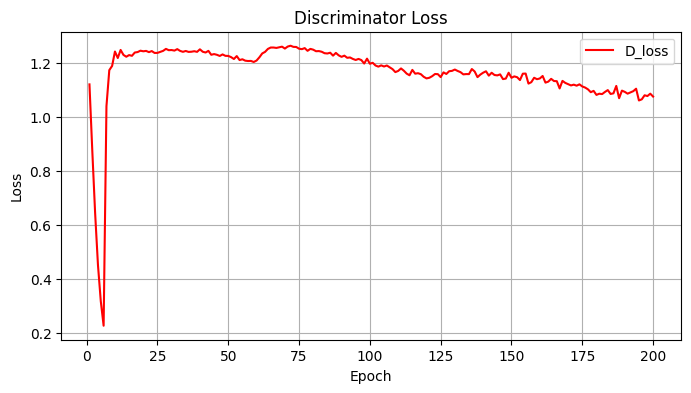

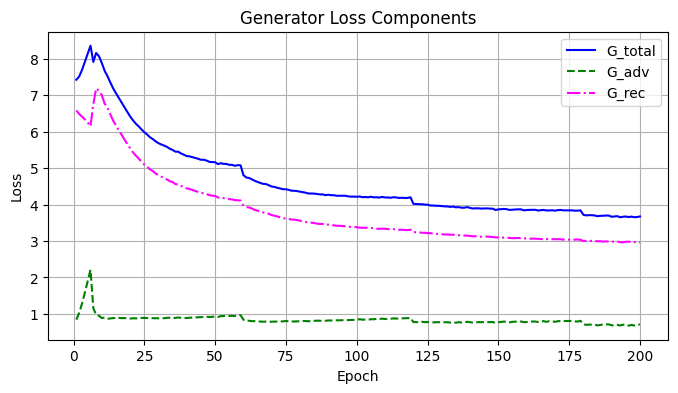

In [10]:
#====================Training logs====================
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

epochs = range(1, len(D_logs) + 1)

# --------- Vẽ D log ---------
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(epochs, D_logs, label="D_loss", color="red")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Discriminator Loss")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # ép tick nguyên
plt.show()

# --------- Vẽ G log ---------
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(epochs, [log["total"] for log in G_logs], label="G_total", color="blue")
ax.plot(epochs, [log["adv"] for log in G_logs], label="G_adv", color="green", linestyle="--")
ax.plot(epochs, [log["rec"] for log in G_logs], label="G_rec", color="magenta", linestyle="-.")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Generator Loss Components")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # ép tick nguyên
plt.show()

In [11]:
#====================Load checkpoint====================
G_50 = UNetGenerator().to(device)
G_100 = UNetGenerator().to(device)
G_150 = UNetGenerator().to(device)
G_200 = UNetGenerator().to(device)

checkpoint = torch.load("epoch_50.pth", map_location=device)
G_50.load_state_dict(checkpoint["G_state"])
checkpoint = torch.load("epoch_100.pth", map_location=device)
G_100.load_state_dict(checkpoint["G_state"])
checkpoint = torch.load("epoch_150.pth", map_location=device)
G_150.load_state_dict(checkpoint["G_state"])
checkpoint = torch.load("epoch_200.pth", map_location=device)
G_200.load_state_dict(checkpoint["G_state"])

<All keys matched successfully>

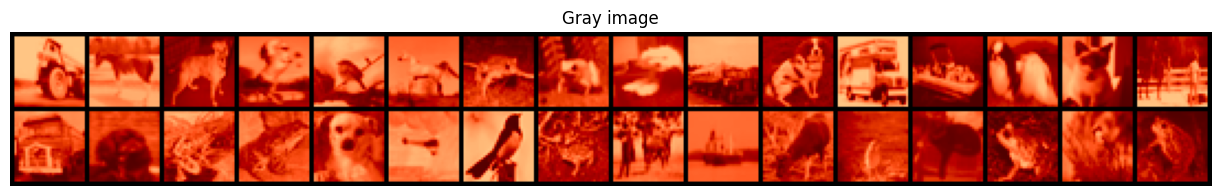

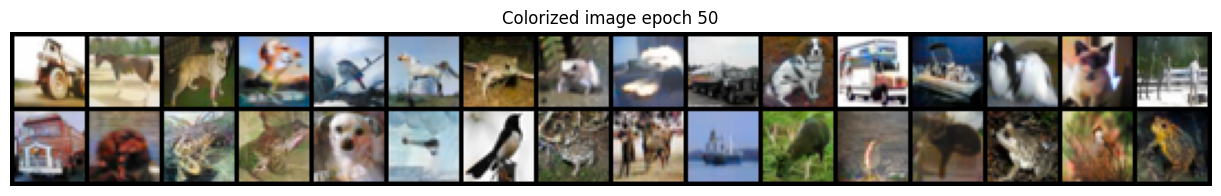

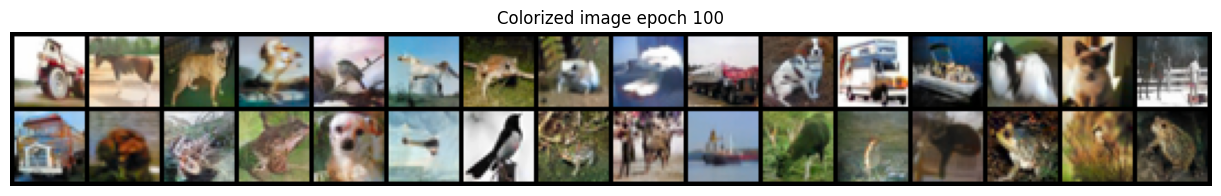

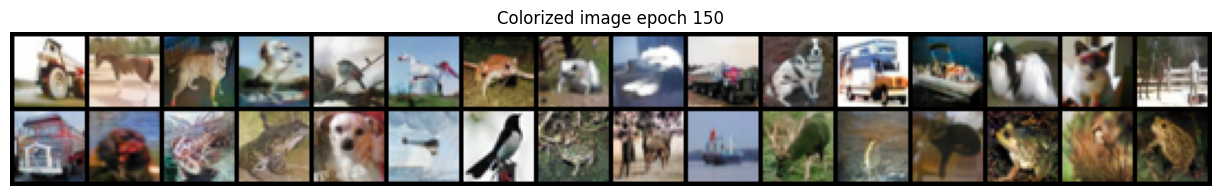

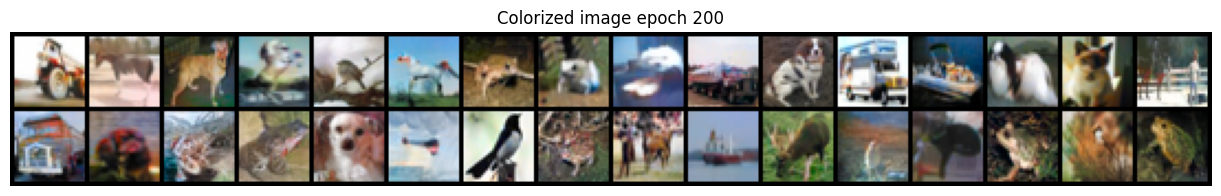

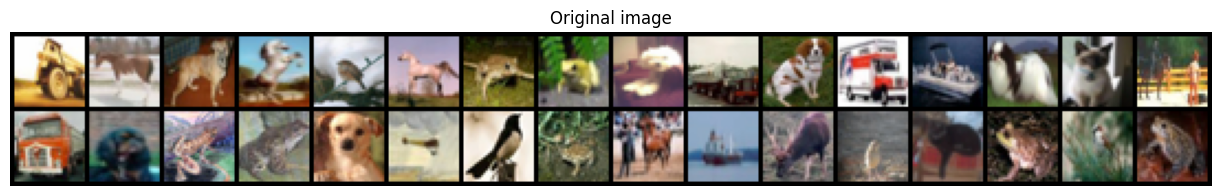

In [12]:
#====================Inference====================
with torch.no_grad():
    L, ab = next(iter(test_dataloader))
    # Show gray image
    B, C, H, W = L.shape
    imshow(L, torch.full((B, 2, H, W), 0.5, dtype=L.dtype), "Gray image")
    
    # Show colorized image
    L = L.to(device)
    ab_hat = G_50(L)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    imshow(L, ab_hat, "Colorized image epoch 50")
    
    # Show colorized image
    L = L.to(device)
    ab_hat = G_100(L)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    imshow(L, ab_hat, "Colorized image epoch 100")

    # Show colorized image
    L = L.to(device)
    ab_hat = G_150(L)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    imshow(L, ab_hat, "Colorized image epoch 150")

    # Show colorized image
    L = L.to(device)
    ab_hat = G_200(L)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    imshow(L, ab_hat, "Colorized image epoch 200")
    
    # Show orignal image
    imshow(L, ab, "Original image")